In [24]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from datetime import datetime


In [26]:
# Función para obtener el nombre del día de la semana
def get_weekday_name(day, month,year):
    meses_dict = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    month_num = meses_dict[month.lower()]  # Convierte el nombre del mes a número
    date_obj = datetime(year, month_num, day)
    return date_obj.strftime('%A')  # Devuelve el nombre completo del día de la semana

In [27]:
def cleaning(data):
    cond_balance = [(data['balance'] < 0),(data['balance'] >= 0) & (data['balance'] < 100),(data['balance'] >= 100) & (data['balance'] < 500),(data['balance'] >= 500) & (data['balance'] < 1000),  (data['balance'] >= 1000) & (data['balance'] < 1500),  (data['balance'] >= 1500)] 
    cond_duration = [(data['duration'] >= 0) & (data['duration'] < 5),(data['duration'] >= 5) & (data['duration'] < 10),(data['duration'] > 10)]
    choice_balance = ['negativo', '0-100', '100-500','500-1000', '1000-1500', ' > 1500'] 
    choice_duration = ['<5', '5 - 10', '10>0 ']
    year=2020
    dias_semana_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    data['balance'] = np.select(cond_balance, choice_balance, default='Other')
    data['duration'] = data['duration']/60
    data['duration'] = np.select(cond_duration, choice_duration, default='Other')
    data['pdays'] = np.where(data['pdays'] == -1, 0, 1)
    data['previous'] = np.where(data['previous'] == 0, 0, 1)
    data['dia_semana'] = data.apply(lambda row: get_weekday_name(row['day'], row['month'],year), axis=1)
    #data['dia_semana'] = pd.Categorical(data['dia_semana'], categories=dias_semana_ordenados, ordered=True)
    data=data[~data['car'].isnull()]
    data=data[~data.duplicated()]
    data['subscribed']=data['subscribed'].map({'yes':1,
                                                 'no':0})
    return data


In [41]:
data_raw=pd.read_csv('../../Data/Raw/bank-full.csv',sep=';')
data_cleaned=cleaning(data_raw)


,age,job,marital,education,default,balance,housing,loan,car,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed,dia_semana
0,58,management,married,tertiary,no,> 1500,yes,no,1,unknown,5,may,10>0,1,0,0,unknown,no,Tuesday
1,44,technician,single,secondary,no,0-100,yes,no,0,unknown,5,may,10>0,1,0,0,unknown,no,Tuesday
2,33,entrepreneur,married,secondary,no,0-100,yes,yes,1,unknown,5,may,10>0,1,0,0,unknown,no,Tuesday
3,47,blue-collar,married,unknown,no,> 1500,yes,no,1,unknown,5,may,10>0,1,0,0,unknown,no,Tuesday
4,33,unknown,single,unknown,no,0-100,no,no,0,unknown,5,may,10>0,1,0,0,unknown,no,Tuesday


<Axes: >

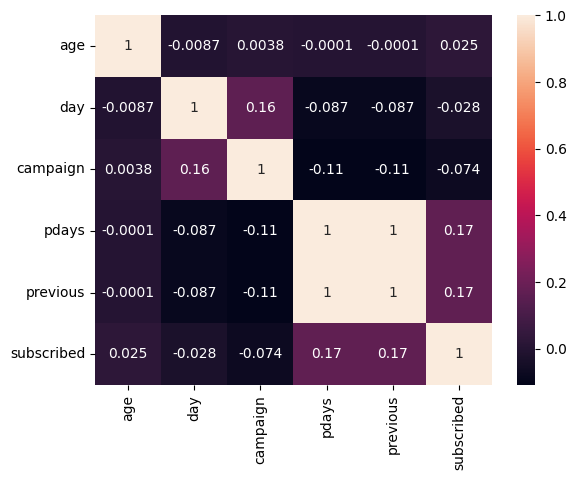

In [29]:
num_cols=data_cleaned.select_dtypes(include='number').columns
sns.heatmap(data_cleaned[num_cols].corr(),annot=True)

In [42]:
data_cleaned.drop('pdays',axis=1,inplace=True)
data_cleaned_cat_num=data_cleaned.copy()    #Para probar seleccion de variables Filter y Wrapper

In [43]:
data_cleaned_cat_num.head()

,age,job,marital,education,default,balance,housing,loan,car,contact,day,month,duration,campaign,previous,poutcome,subscribed,dia_semana
0,58,management,married,tertiary,no,> 1500,yes,no,1,unknown,5,may,10>0,1,0,unknown,0,Tuesday
1,44,technician,single,secondary,no,0-100,yes,no,0,unknown,5,may,10>0,1,0,unknown,0,Tuesday
2,33,entrepreneur,married,secondary,no,0-100,yes,yes,1,unknown,5,may,10>0,1,0,unknown,0,Tuesday
3,47,blue-collar,married,unknown,no,> 1500,yes,no,1,unknown,5,may,10>0,1,0,unknown,0,Tuesday
4,33,unknown,single,unknown,no,0-100,no,no,0,unknown,5,may,10>0,1,0,unknown,0,Tuesday


In [44]:
def cat_to_num(col,objective,data): #Proceso similar al que sigue CatboostClassifier
    dic={}
    for opt in data[col].unique():
        mask=data[col]==opt
        valor=round(data[mask][objective].sum() / len(data[mask]),3)
        dic[opt]=valor

    data[col]=data[col].map(dic)
    data[col]=data[col].astype(float)


In [45]:
cat_cols=data_cleaned.select_dtypes(include=['O']).columns
ids_cat=[id for id,col in enumerate(data_cleaned.columns) if col in cat_cols]

for cl in data_cleaned_cat_num.select_dtypes(include=['O','category']).columns:
    cat_to_num(cl,'subscribed',data_cleaned_cat_num)

In [47]:
data_cleaned_cat_num.head()

,age,job,marital,education,default,balance,housing,loan,car,contact,day,month,duration,campaign,previous,poutcome,subscribed,dia_semana
0,58,0.139,0.102,0.151,0.119,0.165,0.078,0.128,0.102,0.041,5,0.068,0.119,1,0,0.093,0,0.122
1,44,0.111,0.151,0.107,0.119,0.082,0.078,0.128,0.151,0.041,5,0.068,0.119,1,0,0.093,0,0.122
2,33,0.083,0.102,0.107,0.119,0.082,0.078,0.067,0.102,0.041,5,0.068,0.119,1,0,0.093,0,0.122
3,47,0.074,0.102,0.135,0.119,0.165,0.078,0.128,0.102,0.041,5,0.068,0.119,1,0,0.093,0,0.122
4,33,0.115,0.151,0.135,0.119,0.082,0.168,0.128,0.151,0.041,5,0.068,0.119,1,0,0.093,0,0.122


In [48]:
data_cleaned_cat_num.to_csv('/Users/mariolamas/Desktop/PFG-UNAV-G4/Data/Cleaned/bank_full_limpio_v0.csv',index=False)

In [49]:
y=data_cleaned_cat_num['subscribed']
X=data_cleaned_cat_num.drop('subscribed',axis=1)
cat_cols=X.select_dtypes(include=['O']).columns
ids_cat=[id for id,col in enumerate(X.columns) if col in cat_cols]

# Seleccion con Catboost
---

In [50]:
clf=CatBoostClassifier(random_state=0,cat_features=ids_cat)
clf.fit(X,y)

Learning rate set to 0.0522
0:	learn: 0.6478121	total: 14ms	remaining: 14s
1:	learn: 0.6051349	total: 37.5ms	remaining: 18.7s
2:	learn: 0.5677491	total: 59.5ms	remaining: 19.8s
3:	learn: 0.5387029	total: 75.3ms	remaining: 18.7s
4:	learn: 0.5097393	total: 89.3ms	remaining: 17.8s
5:	learn: 0.4848568	total: 99.9ms	remaining: 16.6s
6:	learn: 0.4635776	total: 112ms	remaining: 15.8s
7:	learn: 0.4450978	total: 122ms	remaining: 15.1s
8:	learn: 0.4280406	total: 130ms	remaining: 14.4s
9:	learn: 0.4134164	total: 140ms	remaining: 13.9s
10:	learn: 0.4010195	total: 150ms	remaining: 13.5s
11:	learn: 0.3895254	total: 164ms	remaining: 13.5s
12:	learn: 0.3804657	total: 175ms	remaining: 13.3s
13:	learn: 0.3712017	total: 191ms	remaining: 13.4s
14:	learn: 0.3632465	total: 204ms	remaining: 13.4s
15:	learn: 0.3561080	total: 220ms	remaining: 13.5s
16:	learn: 0.3497321	total: 248ms	remaining: 14.4s
17:	learn: 0.3444460	total: 276ms	remaining: 15.1s
18:	learn: 0.3394763	total: 293ms	remaining: 15.1s
19:	learn: 

In [51]:
result=pd.DataFrame(zip(clf.feature_importances_,clf.feature_names_),columns=['import','var']).sort_values('import',ascending=False)
result

,import,var
11,16.815071,month
10,15.033705,day
0,10.398993,age
15,8.126235,poutcome
9,7.936670,contact
16,7.046549,dia_semana
13,6.294800,campaign
5,5.577773,balance
1,5.022300,job
6,4.936007,housing


## Seleccion con Ridge
---

In [52]:
X_cat_num=data_cleaned_cat_num.drop('subscribed',axis=1)
y_cat_num=data_cleaned_cat_num['subscribed']

In [53]:
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=0.01, solver = 'auto', random_state = 9) #Si selecionamos alpha = 0 se correspondería con una regresión lineal sin penalización
ridge_regression.fit(X_cat_num, y_cat_num)
result=pd.DataFrame(zip(abs(ridge_regression.coef_),X_cat_num.columns),columns=['import','var']).sort_values('import',ascending=False) #Importancias lineales
result

,import,var
12,0.885102,duration
15,0.861555,poutcome
11,0.622736,month
5,0.450735,balance
7,0.421785,loan
6,0.407965,housing
1,0.340389,job
9,0.328737,contact
8,0.299752,car
2,0.299752,marital


In [55]:
data_sin_previous=data_cleaned_cat_num.drop('default',axis=1)
data_sin_previous.to_csv('/Users/mariolamas/Desktop/PFG-UNAV-G4/Data/Cleaned/bank_full_limpio_v0_sindefault.csv',index=False)

# **Conclusiones seleccion de variables**
---
Tras probar la seleccion de variables por correlacion, Ridge y con métodos intrinsecos como Catboost, consideramos que los resultados mas precisos son los proporcionados por catboost ya que la relación entre las variables no es lineal.
En conclusión decidimos no eliminar ninguna variable ya que no lo consideramos necesario, sin embargo, hemos creado una version del dataset procesado sin la variable "default" (Menor importancia segun Catboost) para verificar nuestra hipótesis durante las pruebas de modelos.